# C-sets for data analysis: graphs, relational data, and conjunctive queries

**Evan Patterson**  
[Topos Institute](https://topos.institute/)

**Category Theory and Applications Meetup**  
January 20, 2021

## Introduction

Some common classes of data processing tools:

1. **Data frames**, aka **data tables**
  - `data.frame` in R (originally S)
  - [pandas](https://pandas.pydata.org/) in Python
  - [DataFrames.jl](https://github.com/JuliaData/DataFrames.jl) and others in Julia
2. **Graphs** for graph analytics
  - [NetworkX](https://networkx.org/) in Python
  - [LightGraphs.jl](https://github.com/JuliaGraphs/LightGraphs.jl) in Julia
3. **Relational databases**
  - Best known through SQL databases
  - Also in logic programming, e.g. Prolog

These classes are often considered to be disjoint:

- Different data structures
- Different environments: embedded/in-memory vs standalone systems

But **category theory** suggests a unifying framework:

- Mathematics is now pretty well understood (Spivak, Wisnesky, and others)
- *In this talk*, an implementation in the Julia package [Catlab.jl](https://github.com/AlgebraicJulia/Catlab.jl)

## Graphs and C-sets

The unifying framework is *$\mathcal{C}$-sets*, aka *copresheaves* or *set-valued functors*.

**Definition**. Given a small category $\mathcal{C}$, a *$\mathcal{C}$-set* is a functor $X: \mathcal{C} \to \mathbf{Set}$.

**Interpretation** ([Spivak 2012](https://doi.org/10.1016/j.ic.2012.05.001), [Spivak 2014](https://mitpress.mit.edu/books/category-theory-sciences)):

- category $\mathcal{C}$ is a *schema*
- functor $\mathcal{C} \to \mathbf{Set}$ is instance data, i.e., a database on that schema 

**Example**: The *schema for graphs* is

$$\mathcal{C} = \{E \rightrightarrows V\}$$

In [1]:
using Catlab, Catlab.CategoricalAlgebra

@present SchemaGraphs(FreeSchema) begin
    V::Ob
    E::Ob
    src::Hom(E,V)
    tgt::Hom(E,V)
end;

This object is a *presentation* of a category, which keeps track of

- generators (in this case, two object generators and two morphism generators)
- relations, i.e. equations (in this case, none)

In [2]:
generators(SchemaGraphs, :Hom)

2-element Array{Catlab.Theories.FreeSchema.Hom{:generator},1}:
 src
 tgt

To translate the presentation into a Julia type for a data structure, use `CSetType`:

```julia
const Graph = CSetType(SchemaGraphs, index=[:src,:tgt])
```

**Note**: We won't run this line because it is a copy-paste from `Catlab.Graphs`.

In [3]:
using Catlab.Graphs

g = Graph()
add_parts!(g, :V, 4)
add_parts!(g, :E, 3, src=[1,2,2], tgt=[2,3,4])
g

E,src,tgt
1,1,2
2,2,3
3,2,4


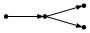

In [4]:
using Catlab.Graphics

to_graphviz(g)

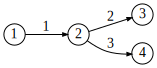

In [5]:
to_graphviz(g, node_labels=true, edge_labels=true)

Catlab includes helper functions for graphs, but they just wrap the C-sets API.

In [6]:
h = Graph()
add_vertices!(h, 4)
add_edges!(h, [1,2,2], [2,3,4])
g == h

true

### C-sets API

The core API for C-sets is simple:

- `add_part(s)!` and `rem_part(s)!`: add and remove parts
- `subpart` and `set_subpart(s)!` (also indexing notation): get/set subparts
- `incident`: inverse images of subparts, using indices if available

Illustrated below in context of `Graphs` API:

In [7]:
subpart(g, 1, :tgt) == tgt(g, 1) # Target vertex of edge 1.

true

In [8]:
incident(g, 2, :src) # Edges having vertex 2 as source.

2-element Array{Int64,1}:
 2
 3

Inverse images needed for efficient graph traversals:

In [9]:
outneighbors(g, 2) == [ tgt(g, e) for e in incident(g, 2, :src) ]

true

### C-sets implementation

In Catlab, a $\mathcal{C}$-set consists of two things, tables and indices.

In [10]:
keys(tables(g))

(:V, :E)

In a graph, $V$-table is trivial (zero columns) and $E$ has two columns:

In [11]:
tables(g)[:E]

Table with 2 columns and 3 rows:
     src  tgt
   ┌─────────
 1 │ 1    2
 2 │ 2    3
 3 │ 2    4

Indices are private and are controlled by `index` keyword to `CSetType`:

```julia
const Graph = CSetType(SchemaGraphs, index=[:src,:tgt])
```

In [12]:
incident(g, :, :src)

4-element view(::Array{Array{Int64,1},1}, :) with eltype Array{Int64,1}:
 [1]
 [2, 3]
 []
 []

Such indices generalize the [adjacency list](https://en.wikipedia.org/wiki/Adjacency_list) representation of a graph.

### Graphs and beyond

Following are $\mathcal{C}$-sets for suitable $\mathcal{C}$:

- "undirected" graphs: symmetric graphs and half-edge graphs
- reflexive graphs
- bipartite graphs
- wiring diagrams, directed and undirected, via `Catlab.WiringDiagrams`
- whole-grain Petri nets ([Kock 2020](https://arxiv.org/abs/2005.05108)), via [AlgebraicPetri.jl](https://github.com/AlgebraicJulia/AlgebraicPetri.jl)
- *coming soon*: simplicial sets, via [CombinatorialSpaces.jl](https://github.com/AlgebraicJulia/CombinatorialSpaces.jl)

## Data frames and attributed C-sets

A **data frame** (or **data table**) with $k$ columns and $n$ rows can be regarded as a *multispan* in $\mathbf{Set}$ with $k$ legs and apex $[n] := \{1,2,\dots,n\}$.

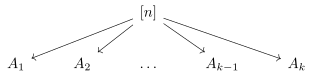

In [13]:
using TikzPictures

# XXX: Hack to increase size by scaling.
TikzPictures.write_adjustbox_options(tex::IO, tp::TikzPicture) =
    println(tex, "\\begin{adjustbox}{scale=$(tp.width)}")

TikzCD(tex::AbstractString) = TikzPicture(
    tex, width="1.5", height="1.5", environment="tikzcd",
    preamble=raw"\usepackage{tikz-cd}\usepackage{amsmath,amssymb}")

TikzCD(raw"""
    && {[n]} \arrow[dll] \arrow[dl] \arrow[dr] \arrow[drr] && \\
    A_1 & A_2 & \dots & A_{k-1} & A_k""")

Can incorporate data attributes into $\mathcal{C}$-sets by

- just adding more objects and morphisms to $\mathcal{C}$, or
- extending the formalism beyond categories and functors  
  ([Schultz, Spivak, Vasilakopoulou, Wisnesky 2017](http://www.tac.mta.ca/tac/volumes/32/16/32-16abs.html))

The former is simpler but the latter is more faithful to computer implementations, including Catlab's implementation of *attributed $\mathcal{C}$-sets*.

### Example: weighted graphs

In [14]:
@present SchemaWeightedGraphs <: SchemaGraphs begin
    Weight::Data
    weight::Attr(E,Weight)
end;

Now would run

```julia
const WeightedGraph = ACSetType(SchemaWeightedGraphs,
                                index=[:src,:tgt])
```

but again, this is built into `Catlab.Graphs`.

In [15]:
g = WeightedGraph{Float64}()
add_vertices!(g, 4)
add_edges!(g, [1,2,2], [2,3,4], weight=[0.5, 1.5, 1.5])
g

E,src,tgt,weight
1,1,2,0.5
2,2,3,1.5
3,2,4,1.5


In [16]:
g[:weight]

3-element Array{Float64,1}:
 0.5
 1.5
 1.5

In [17]:
g[3,:weight] = 2.5

g[:weight]

3-element Array{Float64,1}:
 0.5
 1.5
 2.5

### Technical note: static vs dynamic in Julia

In Julia, data tables ([Tables.jl](https://github.com/JuliaData/Tables.jl) interface) can be:

- **static**, with column spec fully typed, e.g. [TypedTables.jl](https://github.com/JuliaData/TypedTables.jl) and [StructArrays.jl](https://github.com/JuliaArrays/StructArrays.jl), or
- **dynamic**, with columns dependent on the instance, e.g. [DataFrames.jl](https://github.com/JuliaData/DataFrames.jl)

Leads to *compile-time* vs *runtime* tradeoff.

Catlab's implementation of attributed $\mathcal{C}$-sets is statically typed:

- Schema is fully encoded in Julia type
- Accessors and mutators are [`@generated` functions](https://docs.julialang.org/en/v1/manual/metaprogramming/#Generated-functions)
- Pro: Very fast data structures, effectively hand-coded
- Con: Will not scale well with large schemas

Dynamic $\mathcal{C}$-sets are a possibility for the future.

## A simple relational dataset: longitudinal data

[Sitka](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/Sitka.html) dataset from the R package [MASS](https://cran.r-project.org/package=MASS):

- Size measurements of Sitka spruce trees, in treatment (`ozone`) and control (`control`) groups
- Longitudinal data: repeated measurements over time

In [18]:
using DataFrames
import RDatasets

sitka_df = RDatasets.dataset("MASS", "Sitka")
rename!(lowercase, sitka_df)
mapcols!(sitka_df) do col
    # Convert's R 32-bit integers to native integers.
    eltype(col) == Int32 ? collect(Int, col) : col
end

withenv("LINES" => 10) do; display(sitka_df) end

,size,time,tree,treat
,Float64,Int64,Int64,Cat…
1,4.51,152,1,ozone
2,4.98,174,1,ozone
3,5.41,201,1,ozone
4,5.9,227,1,ozone
5,6.15,258,1,ozone
6,4.24,152,2,ozone
7,4.2,174,2,ozone
8,4.68,201,2,ozone
9,4.92,227,2,ozone


As a multispan, the Sitka data frame looks like:

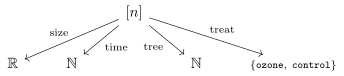

In [19]:
TikzCD(raw"""
    && {[n]} \arrow[dll, "\mathrm{size}"'] \arrow[dl, "\mathrm{time}"]
        \arrow[dr, "\mathrm{tree}"'] \arrow[drr, "\mathrm{treat}"] && \\
      \mathbb{R} & \mathbb{N} & &
      \mathbb{N} & \scriptstyle\{\mathtt{ozone},\ \mathtt{control}\}""")

Structurally, the Sitka dataset has:

- Two-level structure:
  1. *trees*, each with a set of
  2. *measurements*
- Data attributes at both levels

Ignoring attributes, the schema is

$$ \mathcal{C} = \{\mathrm{Tree} \leftarrow \mathrm{Measurement}\} $$

The complete schema and corresponding Julia type are as follows.

In [20]:
@present SitkaSchema(FreeSchema) begin
  (Numerical, Time, Treatment)::Data

  Tree::Ob
  treat::Attr(Tree, Treatment)
  
  Measurement::Ob
  tree::Hom(Measurement, Tree)
  size::Attr(Measurement, Numerical)
  time::Attr(Measurement, Time)
end

const SitkaData = ACSetType(SitkaSchema, index=[:tree]);

Transfer Sitka data from `DataFrame` to `ACSet`.

*Step 1*: Add the trees and measurements.

In [21]:
sitka = SitkaData{Float64,Int,String}()

trees = unique!(sort(sitka_df.tree))
@assert trees == 1:last(trees)
add_parts!(sitka, :Tree, length(trees))
add_parts!(sitka, :Measurement, nrow(sitka_df),
           tree=sitka_df.tree, size=sitka_df.size, time=sitka_df.time)

map(length, tables(sitka))

(Tree = 79, Measurement = 395)

*Step 2*: Assign treatment to each tree, checking for data consistency.

In [22]:
for tree in trees
    measurements = incident(sitka, tree, :tree) # Uses `tree` index.
    sitka[tree, :treat] = only(unique(sitka_df.treat[measurements]))
end

withenv("LINES" => 10) do
    foreach(display∘DataFrame, tables(sitka))
end

,treat
,String
1,ozone
2,ozone
3,ozone
4,ozone
5,ozone
6,ozone
7,ozone
8,ozone
9,ozone


,tree,size,time
,Int64,Float64,Int64
1,1,4.51,152
2,1,4.98,174
3,1,5.41,201
4,1,5.9,227
5,1,6.15,258
6,2,4.24,152
7,2,4.2,174
8,2,4.68,201
9,2,4.92,227


This first example of a *conjunctive query* recovers the original table:

In [23]:
using Catlab.WiringDiagrams, Catlab.Programs

select_all = @relation (size=size, time=time, tree=t, treat=treat) begin
  Tree(_id=t, treat=treat)
  Measurement(tree=t, size=size, time=time)
end

query(sitka, select_all, table_type=DataFrame) == sitka_df

true

We'll see a lot more examples later.

## Another relational dataset: mutagenesis dataset

[mutagenesis](https://web.archive.org/web/20180925162806/http://www.cs.ox.ac.uk/activities/machlearn/mutagenesis.html) dataset from the [Relational Dataset Repository](https://relational.fit.cvut.cz/dataset/Mutagenesis):

- From study on mutagenicity of certain chemical compounds
- Three-level structure:
  1. *molecules*, which contain
  2. *atoms*, which are connected by
  3. *bonds*
- Data attributes at all three levels

Ignoring attributes, the schema is

$$ \mathcal{C} = \{\mathrm{Molecule} \leftarrow \mathrm{Atom} \leftleftarrows \mathrm{Bonds}\} $$

The complete schema and Julia type are:

In [24]:
@present MutagenesisSchema(FreeSchema) begin
  (Indicator, Categorical, Name, Numerical)::Data
  
  Molecule::Ob
  molecule_id::Attr(Molecule, Name)
  (ind1, inda)::Attr(Molecule, Indicator)
  (logp, lumo)::Attr(Molecule, Numerical)
  mutagenic::Attr(Molecule, Indicator)
  
  Atom::Ob
  molecule::Hom(Atom, Molecule)
  atom_id::Attr(Atom, Name)
  atom_type::Attr(Atom, Categorical)
  element::Attr(Atom, Name)
  charge::Attr(Atom, Numerical)
  
  Bond::Ob
  (atom1, atom2)::Hom(Bond, Atom)
  bond_type::Attr(Bond, Categorical)
end

const MutagenesisData = ACSetType(MutagenesisSchema, 
  index=[:atom1, :atom2, :molecule],
  unique_index=[:atom_id, :molecule_id]);

Now we load the data from a SQL database where it is stored.

**Note**: In future work, we should automate both conversions:

- SQL schema $\to$ `Schema` presentation
- SQL database $\to$ `AttributedCSet`

In [25]:
using MySQL
using NamedTupleTools: delete

mutagenesis = MutagenesisData{Bool,Int,String,Float64}()

db = DBInterface.connect(MySQL.Connection, "relational.fit.cvut.cz",
                         "guest", "relational", db="mutagenesis")
for row in DBInterface.execute(db, "SELECT * FROM molecule;")
  tuple = NamedTuple(row)
  add_part!(mutagenesis, :Molecule, merge(tuple, (
    mutagenic = row.mutagenic == "yes",
  )))
end
for row in DBInterface.execute(db, "SELECT * FROM atom;")
  tuple = delete(NamedTuple(row), :molecule_id, :type)
  add_part!(mutagenesis, :Atom, merge(tuple, (
    molecule = incident(mutagenesis, row.molecule_id, :molecule_id),
    atom_type = row.type,
  )))
end
for row in DBInterface.execute(db, "SELECT * from bond;")
  tuple = delete(NamedTuple(row), :atom1_id, :atom2_id, :type)
  add_part!(mutagenesis, :Bond, merge(tuple, (
    atom1 = incident(mutagenesis, row.atom1_id, :atom_id),
    atom2 = incident(mutagenesis, row.atom2_id, :atom_id),
    bond_type = row.type,
  )))
end
close(db)

map(length, tables(mutagenesis))

(Molecule = 188, Atom = 4893, Bond = 5243)

In [26]:
withenv("LINES" => 10) do
    foreach(display∘DataFrame, tables(mutagenesis))
end

,molecule_id,ind1,inda,logp,lumo,mutagenic
,String,Bool,Bool,Float64,Float64,Bool
1,d1,1,0,4.23,-1.246,1
2,d10,1,0,4.62,-1.387,1
3,d100,0,0,2.68,-1.034,0
4,d101,1,0,6.26,-1.598,1
5,d102,1,0,2.4,-3.172,1
6,d103,1,0,4.69,-1.487,1
7,d104,1,0,6.26,-1.546,1
8,d105,1,0,1.84,-1.749,1
9,d106,1,0,4.34,-1.607,1


,molecule,atom_id,atom_type,element,charge
,Int64,String,Int64,String,Float64
1,3,d100_1,22,c,-0.128
2,3,d100_10,3,h,0.132
3,3,d100_11,29,c,0.002
4,3,d100_12,22,c,-0.128
5,3,d100_13,22,c,-0.128
6,3,d100_14,22,c,-0.128
7,3,d100_15,22,c,0.202
8,3,d100_16,22,c,-0.128
9,3,d100_17,3,h,0.132


,atom1,atom2,bond_type
,Int64,Int64,Int64
1,1,12,7
2,1,24,1
3,3,4,7
4,4,5,7
5,4,9,1
6,5,6,7
7,5,10,1
8,6,7,7
9,6,11,1


### Underlying graph of mutagenesis data

The mutagenesis dataset is essentially an indexed collection of graphs.

Can easily extract a graph using **functorial data migration** ("$\Delta$ migration functor"):

In [27]:
mutagenesis_graph = Graph(mutagenesis,
    Dict(:V => :Atom, :E => :Bond),
    Dict(:src => :atom1, :tgt => :atom2))

(V = nv(mutagenesis_graph), E = ne(mutagenesis_graph))

(V = 4893, E = 5243)

Connected components of graph correspond to molecules:

In [28]:
components = connected_components(mutagenesis_graph)
length(components)

188

Mainly useful for routines that expect to receive a graph as input.

## Conjunctive queries on C-sets

Conjunctive queries are:

- useful class of SQL queries in practice
- important in relational database theory
- the queries corresponding to [regular logic](https://ncatlab.org/nlab/show/regular+logic) ($\exists, \wedge, \top$)
- have a graphical syntax via undirected wiring diagrams  
  ([Spivak 2013](https://arxiv.org/abs/1305.0297), [Fong & Spivak 2018](https://arxiv.org/abs/1812.05765))

In Catlab, conjunctive queries are:

- represented by undirected wiring diagrams
- most easily created using the `@relation` macro
- executable against any attributed $\mathcal{C}$-set

Will be explained by example.

### Conjunctive queries on mutagenesis data

First query:

> Find bonds between atoms that belong to the same molecule.

**Note**: This should be all of the bonds!

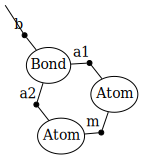

In [29]:
bond_within_molecule = @relation (Bond=b) begin
  Bond(_id=b, atom1=a1, atom2=a2)
  Atom(_id=a1, molecule=m)
  Atom(_id=a2, molecule=m)
end

to_graphviz(bond_within_molecule,
            box_labels=:name, junction_labels=:variable)

In [30]:
result = query(mutagenesis, bond_within_molecule)
length(result) == nparts(mutagenesis, :Bond)

true

**Aside**: It would be good practice to add this constraint to the schema as a relation:

```julia
@present MutagenesisSchema(FreeSchema) begin
  [...]
  
  compose(atom1, molecule) == compose(atom2, molecule)
end
```

**Question**: Is the underlying graph really symmetric?

Formulate as query:

> Find pairs of atoms with bonds going in both directions.

In [31]:
symmetric_pairs = @relation (atom1=a1, atom2=a2) begin
  Bond(atom1=a1, atom2=a2)
  Bond(atom1=a2, atom2=a1)
end

length(query(mutagenesis, symmetric_pairs))

0

**Answer**: No, in fact, there are not any symmetric edge pairs.

Let's look at paths in the molecular graphs.

First, formulate in graph constructed above:

> Find all directed paths of length 2.

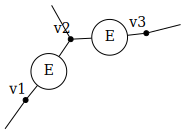

In [32]:
paths2 = @relation (vert1=v1, vert2=v2, vert3=v3) begin
  E(src=v1, tgt=v2)
  E(src=v2, tgt=v3)
end

to_graphviz(paths2, box_labels=:name, junction_labels=:variable)

In [33]:
result = query(mutagenesis_graph, paths2)

withenv("LINES" => 15) do; display(result) end

Table with 3 columns and 5539 rows:
     vert1  vert2  vert3
   ┌────────────────────
 1 │ 1      12     20
 2 │ 1      12     25
 3 │ 3      4      5
 4 │ 3      4      9
 5 │ 4      5      6
 6 │ 4      5      10
 7 │ 5      6      7
 8 │ 5      6      11
 ⋮ │   ⋮      ⋮      ⋮

But better to formulate against original data, where more expressive queries are possible, e.g.

> Find all directed paths from a carbon atom to a nitrogen atom to
another carbon atom.

This also illustrates the use of *query parameters*.

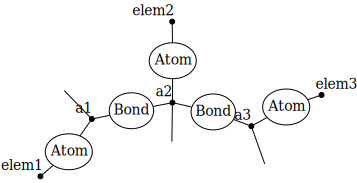

In [34]:
paths2 = @relation (atom1=a1, atom2=a2, atom3=a3) begin
  Bond(atom1=a1, atom2=a2)
  Bond(atom1=a2, atom2=a3)
  Atom(_id=a1, element=elem1)
  Atom(_id=a2, element=elem2)
  Atom(_id=a3, element=elem3)
end

to_graphviz(paths2, box_labels=:name, junction_labels=:variable)

In [35]:
result = query(mutagenesis, paths2,
               (elem1="c", elem2="n", elem3="c"))

withenv("LINES" => 15) do; display(result) end

Table with 3 columns and 41 rows:
     atom1  atom2  atom3
   ┌────────────────────
 1 │ 163    164    165
 2 │ 169    170    163
 3 │ 620    624    608
 4 │ 768    769    787
 5 │ 786    766    767
 6 │ 1105   1104   1086
 7 │ 1315   1319   1320
 8 │ 1316   1321   1320
 ⋮ │   ⋮      ⋮      ⋮

The results table is much smaller than before.

## Conclusion

- Graphs, data frames, and relational databases are often treated as inhabiting separate universes
- But they don't have to!
- Category theory provides the mathematics to build unified tools
- We are implementing them in [Catlab.jl](https://github.com/AlgebraicJulia/Catlab.jl)

### Acknowledgments

Contributors to Catlab and other AlgebraicJulia projects:

- Andrew Baas
- James Fairbanks
- Micah Halter
- Sophie Libkind 
- Owen Lynch

### Resources

Second half of talk based on recent blog post:

> [C-sets for data analysis: relational data and conjunctive queries](https://www.algebraicjulia.org/blog/post/2020/12/cset-conjunctive-queries/)  
> December 28, 2020

Blog post also discusses equivalence between:

- conjunctive queries on relational databases
- finite limits in $\mathbf{FinSet}$

For additional topics, see the AlgebraicJulia [website](https://www.algebraicjulia.org/) and [blog](https://www.algebraicjulia.org/blog/).

Talk to us at #catlab.jl channel in [Julia Zulip](https://julialang.zulipchat.com/)!